## Setting up the Dataset

We will only need pandas and numpy for this exercise

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import norm

Read in the parquet file

In [2]:
df = pd.read_parquet("retail_flow_daily.parquet")
df.date = pd.to_datetime(df.date)

Preview of the data

In [4]:
df

,date,ticker,volume_buy,volume_sell,vwap_buy,vwap_sell
0,2016-01-04,A,28418,30233,40.60,40.54
1,2016-01-04,AAL,448009,437415,40.79,40.83
2,2016-01-04,AAP,45070,31598,152.29,152.02
3,2016-01-04,AAPL,3030463,2640489,103.91,103.84
4,2016-01-04,ABBV,307619,291025,57.25,57.28
...,...,...,...,...,...,...
737373,2022-01-12,YUM,32884,22201,129.42,129.34
737374,2022-01-12,ZBH,36345,33526,125.55,125.57
737375,2022-01-12,ZBRA,8247,10603,540.16,539.90
737376,2022-01-12,ZION,15185,18586,70.26,70.23


Sort values by ticker, and then by date

In [5]:
df = df.sort_values(by=["ticker", "date"]).reset_index(drop=True)
df

,date,ticker,volume_buy,volume_sell,vwap_buy,vwap_sell
0,2016-01-04,A,28418,30233,40.60,40.54
1,2016-01-05,A,19296,44676,40.61,40.55
2,2016-01-06,A,20349,28888,40.57,40.69
3,2016-01-07,A,41094,38699,39.25,39.22
4,2016-01-08,A,32187,25654,38.83,38.87
...,...,...,...,...,...,...
737373,2022-01-06,ZTS,51517,38158,218.14,217.93
737374,2022-01-07,ZTS,37964,41849,212.91,212.95
737375,2022-01-10,ZTS,45634,41837,210.72,210.49
737376,2022-01-11,ZTS,46331,40148,211.44,211.37


Create a column full of 1's. This will allow us to easily see how many days have passed (since we'll be looking at previous x trading days.

In [6]:
df["ones"] = 1

Index by ticker and date, and then cumulative sum the data

In [7]:
df_grouped = df.groupby(["ticker", "date"]).sum().groupby(level=0).cumsum()
df_grouped

volume_buy  volume_sell   vwap_buy  vwap_sell  ones
ticker date                                                           
A      2016-01-04       28418        30233      40.60      40.54     1
       2016-01-05       47714        74909      81.21      81.09     2
       2016-01-06       68063       103797     121.78     121.78     3
       2016-01-07      109157       142496     161.03     161.00     4
       2016-01-08      141344       168150     199.86     199.87     5
...                       ...          ...        ...        ...   ...
ZTS    2022-01-06    68433030     64925805  161743.90  161727.86  1515
       2022-01-07    68470994     64967654  161956.81  161940.81  1516
       2022-01-10    68516628     65009491  162167.53  162151.30  1517
       2022-01-11    68562959     65049639  162378.97  162362.67  1518
       2022-01-12    68603187     65085979  162591.86  162575.38  1519

[737378 rows x 5 columns]

In [8]:
nates_df_grouped = df_grouped.copy(deep=True).reset_index()
df_grouped = df_grouped.reset_index(drop=True)
nates_df_grouped

,ticker,date,volume_buy,volume_sell,vwap_buy,vwap_sell,ones
0,A,2016-01-04,28418,30233,40.60,40.54,1
1,A,2016-01-05,47714,74909,81.21,81.09,2
2,A,2016-01-06,68063,103797,121.78,121.78,3
3,A,2016-01-07,109157,142496,161.03,161.00,4
4,A,2016-01-08,141344,168150,199.86,199.87,5
...,...,...,...,...,...,...,...
737373,ZTS,2022-01-06,68433030,64925805,161743.90,161727.86,1515
737374,ZTS,2022-01-07,68470994,64967654,161956.81,161940.81,1516
737375,ZTS,2022-01-10,68516628,65009491,162167.53,162151.30,1517
737376,ZTS,2022-01-11,68562959,65049639,162378.97,162362.67,1518


Factor 1: percent change over the last 20 trading days relative to prior 20 trading day period.

In [9]:
def calc_factor1(single_group: pd.Series) -> pd.Series:
    """
    Factor 1: percent change over the last 20 trading days relative to prior 20 trading
    day period.

    Assumes that `single_group` contains only data from a single ticker,
    sorted from earliest to latest
    """
    cur_buy_change = single_group - single_group.shift(19)
    prev_buy_change = single_group.shift(20) - single_group.shift(39)
    return (cur_buy_change - prev_buy_change) / prev_buy_change


factor1 = (
    nates_df_grouped.groupby("ticker", group_keys=True)
    .volume_buy.apply(calc_factor1)
    .reset_index(drop=True)
)

Factor 2: Total volume buys in the last 20 trading days

In [10]:
def calc_factor2(single_group: pd.DataFrame) -> pd.Series:
    """
    Factor 2: Total volume buys in the last 20 trading days

    Assumes that `single_group` contains only data from a single ticker,
    sorted from earliest to latest
    """
    return single_group - single_group.shift(19)


factor2 = (
    nates_df_grouped.groupby("ticker", group_keys=True)
    .volume_buy.apply(calc_factor2)
    .reset_index(drop=True)
)


Add factor1, factor 2, and the number of days column to the original dataframe, since the third factor doesn't need cumulative sum data.

In [11]:
df['trading_days'] = df_grouped['ones']
df['factor_1'] = factor1
df['factor_2'] = factor2
df

,date,ticker,volume_buy,volume_sell,vwap_buy,vwap_sell,ones,trading_days,factor_1,factor_2
0,2016-01-04,A,28418,30233,40.60,40.54,1,1,NaN,NaN
1,2016-01-05,A,19296,44676,40.61,40.55,1,2,NaN,NaN
2,2016-01-06,A,20349,28888,40.57,40.69,1,3,NaN,NaN
3,2016-01-07,A,41094,38699,39.25,39.22,1,4,NaN,NaN
4,2016-01-08,A,32187,25654,38.83,38.87,1,5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
737373,2022-01-06,ZTS,51517,38158,218.14,217.93,1,1515,0.265450,613808.0
737374,2022-01-07,ZTS,37964,41849,212.91,212.95,1,1516,0.287745,625472.0
737375,2022-01-10,ZTS,45634,41837,210.72,210.49,1,1517,0.324024,654110.0
737376,2022-01-11,ZTS,46331,40148,211.44,211.37,1,1518,0.379862,677184.0


Factor 3: Cosine similarity of monthly volume buys

In [12]:
factor3 = []
for idx in df.index:
    if df["trading_days"][idx] >= 40:
        cur20 = df.loc[(idx - 19) : idx, ["volume_buy"]].to_numpy().flatten()
        prev20 = df.loc[(idx - 39) : (idx - 20), ["volume_buy"]].to_numpy().flatten()
        cosine = np.dot(cur20, prev20) / (norm(cur20) * norm(prev20))

        dif = np.sum(cur20) - np.sum(prev20)

        if dif >= 0:
            direction = 1
        else:
            direction = -1

        factor3.append((cosine * direction))
    else:
        factor3.append(None)

factor3 = pd.Series(factor3)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000


In [14]:
df['factor_3'] = factor3
df

,date,ticker,volume_buy,volume_sell,vwap_buy,vwap_sell,ones,trading_days,factor_1,factor_2,factor_3
0,2016-01-04,A,28418,30233,40.60,40.54,1,1,NaN,NaN,NaN
1,2016-01-05,A,19296,44676,40.61,40.55,1,2,NaN,NaN,NaN
2,2016-01-06,A,20349,28888,40.57,40.69,1,3,NaN,NaN,NaN
3,2016-01-07,A,41094,38699,39.25,39.22,1,4,NaN,NaN,NaN
4,2016-01-08,A,32187,25654,38.83,38.87,1,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
737373,2022-01-06,ZTS,51517,38158,218.14,217.93,1,1515,0.265450,613808.0,0.875011
737374,2022-01-07,ZTS,37964,41849,212.91,212.95,1,1516,0.287745,625472.0,0.876945
737375,2022-01-10,ZTS,45634,41837,210.72,210.49,1,1517,0.324024,654110.0,0.879861
737376,2022-01-11,ZTS,46331,40148,211.44,211.37,1,1518,0.379862,677184.0,0.876338


Add in the pricing data to the dataset

In [15]:
px_data = pd.read_parquet('equity_prices.parquet')

In [16]:
px_data = (
    px_data.sort_values(by=["ticker", "date"])
    .reset_index(drop=True)
    .drop_duplicates(subset=["ticker", "date"])
)

In [17]:
df['date'] =  pd.to_datetime(df['date'])
px_data['date'] =  pd.to_datetime(px_data['date'])
df = pd.merge(df, px_data, how='left', on=['ticker', 'date'])
df

,date,ticker,volume_buy,volume_sell,vwap_buy,vwap_sell,ones,trading_days,factor_1,factor_2,factor_3,open,high,low,close,volume,closeadj,closeunadj,lastupdated
0,2016-01-04,A,28418,30233,40.60,40.54,1,1,NaN,NaN,NaN,41.06,41.190,40.340,40.69,3287335.0,38.614,40.69,2022-04-04
1,2016-01-05,A,19296,44676,40.61,40.55,1,2,NaN,NaN,NaN,40.73,40.950,40.340,40.55,2587246.0,38.481,40.55,2022-04-04
2,2016-01-06,A,20349,28888,40.57,40.69,1,3,NaN,NaN,NaN,40.24,40.990,40.050,40.73,2103619.0,38.652,40.73,2022-04-04
3,2016-01-07,A,41094,38699,39.25,39.22,1,4,NaN,NaN,NaN,40.14,40.150,38.810,39.00,3504314.0,37.010,39.00,2022-04-04
4,2016-01-08,A,32187,25654,38.83,38.87,1,5,NaN,NaN,NaN,39.22,39.705,38.465,38.59,3736768.0,36.621,38.59,2022-04-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737373,2022-01-06,ZTS,51517,38158,218.14,217.93,1,1515,0.265450,613808.0,0.875011,215.48,220.560,213.625,217.42,3103375.0,217.068,217.42,2022-01-19
737374,2022-01-07,ZTS,37964,41849,212.91,212.95,1,1516,0.287745,625472.0,0.876945,217.13,217.420,210.780,211.09,2206472.0,210.749,211.09,2022-01-19
737375,2022-01-10,ZTS,45634,41837,210.72,210.49,1,1517,0.324024,654110.0,0.879861,208.12,212.600,206.160,212.60,2232177.0,212.256,212.60,2022-01-19
737376,2022-01-11,ZTS,46331,40148,211.44,211.37,1,1518,0.379862,677184.0,0.876338,212.00,213.150,208.235,212.80,2281333.0,212.456,212.80,2022-01-19


Add in the ticker metadata

In [18]:
metadata = pd.read_csv('tickers_and_metadata.csv')
metadata = metadata[['ticker', 'sector']]

In [19]:
df = pd.merge(df, metadata, how='left', on=['ticker'])
df

,date,ticker,volume_buy,volume_sell,vwap_buy,vwap_sell,ones,trading_days,factor_1,factor_2,factor_3,open,high,low,close,volume,closeadj,closeunadj,lastupdated,sector
0,2016-01-04,A,28418,30233,40.60,40.54,1,1,NaN,NaN,NaN,41.06,41.19,40.340,40.69,3287335.0,38.614,40.69,2022-04-04,Healthcare
1,2016-01-04,A,28418,30233,40.60,40.54,1,1,NaN,NaN,NaN,41.06,41.19,40.340,40.69,3287335.0,38.614,40.69,2022-04-04,Healthcare
2,2016-01-05,A,19296,44676,40.61,40.55,1,2,NaN,NaN,NaN,40.73,40.95,40.340,40.55,2587246.0,38.481,40.55,2022-04-04,Healthcare
3,2016-01-05,A,19296,44676,40.61,40.55,1,2,NaN,NaN,NaN,40.73,40.95,40.340,40.55,2587246.0,38.481,40.55,2022-04-04,Healthcare
4,2016-01-06,A,20349,28888,40.57,40.69,1,3,NaN,NaN,NaN,40.24,40.99,40.050,40.73,2103619.0,38.652,40.73,2022-04-04,Healthcare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462600,2022-01-10,ZTS,45634,41837,210.72,210.49,1,1517,0.324024,654110.0,0.879861,208.12,212.60,206.160,212.60,2232177.0,212.256,212.60,2022-01-19,Healthcare
1462601,2022-01-11,ZTS,46331,40148,211.44,211.37,1,1518,0.379862,677184.0,0.876338,212.00,213.15,208.235,212.80,2281333.0,212.456,212.80,2022-01-19,Healthcare
1462602,2022-01-11,ZTS,46331,40148,211.44,211.37,1,1518,0.379862,677184.0,0.876338,212.00,213.15,208.235,212.80,2281333.0,212.456,212.80,2022-01-19,Healthcare
1462603,2022-01-12,ZTS,40228,36340,212.89,212.71,1,1519,0.427329,691127.0,0.879128,216.04,216.31,211.160,212.81,2451401.0,212.466,212.81,2022-01-19,Healthcare


In [20]:
df = df.drop_duplicates()

In [21]:
df = df[df['ticker'] != 'DISCA']
df = df[df['ticker'] != 'DOW']
df = df[df['ticker'] != 'FOX']
df = df[df['ticker'] != 'FOXA']
df = df[df['ticker'] != 'IR']
df = df[df['ticker'] != 'UA']

df = df.reset_index(drop=True)

## Portfolio Selection

Function for selecting the top X% of stocks based on a given factor. We select the top X% of stocks in each sector so that the resulting portfolio can be sector neutral. The resulting list will be the list of stocks to go long.

In [22]:
def portfolio_selector_longs(df, day, factor, percentage=0.20):
    df_day = df[df["date"] == day]
    sectors = df_day["sector"].unique()

    array_list = []

    for sector in sectors:
        df_day_sector = df_day[df_day["sector"] == sector]

        n = round(df_day_sector["ticker"].nunique() * percentage)

        df_day_sector_largest = df_day_sector.nlargest(n=n, columns=[factor])

        tickers = df_day_sector_largest["ticker"].unique()

        array_list.append(tickers)

    portfolio = np.concatenate(array_list)
    return portfolio


Function for selecting the bottom X% of stocks based on a given factor. We select the bottom X% of stocks in each sector so that the resulting portfolio can be sector neutral. The resulting list will be the list of stocks to short.

In [23]:
def portfolio_selector_shorts(df, day, factor, percentage=0.20):
    df_day = df[df["date"] == day]
    sectors = df_day["sector"].unique()

    array_list = []

    for sector in sectors:
        df_day_sector = df_day[df_day["sector"] == sector]

        n = round(df_day_sector["ticker"].nunique() * percentage)

        df_day_sector_largest = df_day_sector.nsmallest(n=n, columns=[factor])

        tickers = df_day_sector_largest["ticker"].unique()

        array_list.append(tickers)

    portfolio = np.concatenate(array_list)
    return portfolio


Calculating the returns of a list of stocks to short. The idea behind a short is that you think the stock is overvalued and likely to drop in price. You borrow a stock, immediately sell it, and purchase it (hopefully) at a lower price to return back. Selling date is the start date, and ending date is the purchase date.

In [24]:
def calculate_returns_shorts(df, tickers, sell_date, purchase_date):
    df_sdate = df[df["date"] == sell_date]
    df_pdate = df[df["date"] == purchase_date]

    sell_prices = []
    purchase_prices = []
    for ticker in tickers:
        df_pdate_ticker = df_pdate[df_pdate["ticker"] == ticker]
        df_pdate_ticker.reset_index(drop=True)

        df_sdate_ticker = df_sdate[df_sdate["ticker"] == ticker]
        df_sdate_ticker.reset_index(drop=True)

        if df_pdate_ticker.empty or df_sdate_ticker.empty:
            sell_prices.append(float("nan"))
            purchase_prices.append(float("nan"))
        else:
            purchase_prices.append(df_pdate_ticker.iloc[0]["close"])
            sell_prices.append(df_sdate_ticker.iloc[0]["open"])

    stock_level_earnings = np.subtract(sell_prices, purchase_prices)
    stock_level_pct_earnings = np.divide(stock_level_earnings, sell_prices)

    return stock_level_pct_earnings


Calculating the returns of a list of stocks to go long. Purchase date is the start date, and the ending date is the selling date. We want the price at the selling date to be higher than the price at the purchase date.

In [25]:
def calculate_returns_longs(df, tickers, purchase_date, sell_date):
    df_pdate = df[df["date"] == purchase_date]
    df_sdate = df[df["date"] == sell_date]

    purchase_prices = []
    sell_prices = []
    for ticker in tickers:
        df_pdate_ticker = df_pdate[df_pdate["ticker"] == ticker]
        df_pdate_ticker.reset_index(drop=True)

        df_sdate_ticker = df_sdate[df_sdate["ticker"] == ticker]
        df_sdate_ticker.reset_index(drop=True)

        if df_pdate_ticker.empty or df_sdate_ticker.empty:
            purchase_prices.append(float("nan"))
            sell_prices.append(float("nan"))
        else:
            purchase_prices.append(df_pdate_ticker.iloc[0]["open"])
            sell_prices.append(df_sdate_ticker.iloc[0]["close"])

    stock_level_earnings = np.subtract(sell_prices, purchase_prices)
    stock_level_pct_earnings = np.divide(stock_level_earnings, purchase_prices)

    return stock_level_pct_earnings


Remove null values from the dataset for dates where a factor couldn't be produced since there weren't enough historical datapoints

In [26]:
df_filtered = df.dropna(subset=["factor_1", "factor_2", "factor_3"])

List of items to iterate through

In [27]:
dates = df_filtered["date"].unique()
holding_periods = [1, 2, 3, 4, 5, 10, 15, 20, 40, 60, 80]
percentages = [0.05, 0.10, 0.15, 0.20]
factors = ["factor_1", "factor_2", "factor_3"]

Create empty dataframe to append to

In [36]:
columns = [
    "factor",
    "holding_period",
    "cut_off",
    "realized_return_date",
    "side",
    "return",
]
results_df = pd.DataFrame(columns=columns)

Iterate through each factor, holding period, and cut off, calculating each days return given the selected options for those variables.

In [ ]:
for factor in factors:
    for holding_period in holding_periods:
        for cut_off in percentages:
            adj_holding_period = holding_period - 1

            for idx in range(0, len(dates) - adj_holding_period - 1):
                selection_date = dates[idx]
                start_date = dates[idx + 1]
                end_date = dates[idx + adj_holding_period + 1]

                longs = portfolio_selector_longs(
                    df=df_filtered,
                    day=selection_date,
                    factor=factor,
                    percentage=cut_off,
                )
                shorts = portfolio_selector_shorts(
                    df=df_filtered,
                    day=selection_date,
                    factor=factor,
                    percentage=cut_off,
                )

                longs_returns_pct = calculate_returns_longs(
                    df=df_filtered,
                    tickers=longs,
                    purchase_date=start_date,
                    sell_date=end_date,
                )
                shorts_returns_pct = calculate_returns_shorts(
                    df=df_filtered,
                    tickers=shorts,
                    sell_date=start_date,
                    purchase_date=end_date,
                )

                longs_return_total = np.mean(longs_returns_pct)
                shorts_return_total = np.mean(shorts_returns_pct)

                # add long dataframe
                factor_array = [factor]
                holding_period_array = [holding_period]
                cut_off_array = [cut_off]
                return_date_array = [end_date]
                side_array = ["long"]

                dictionary_l = {
                    "factor": factor_array,
                    "holding_period": holding_period_array,
                    "cut_off": cut_off_array,
                    "realized_return_date": return_date_array,
                    "side": side_array,
                    "return": longs_return_total,
                }
                add_df = pd.DataFrame(data=dictionary_l)
                results_df = pd.concat([results_df, add_df], axis=0)

                # add short dataframe
                side_array = ["short"]

                dictionary_s = {
                    "factor": factor_array,
                    "holding_period": holding_period_array,
                    "cut_off": cut_off_array,
                    "realized_return_date": return_date_array,
                    "side": side_array,
                    "return": shorts_return_total,
                }
                add_df = pd.DataFrame(data=dictionary_s)
                results_df = pd.concat([results_df, add_df], axis=0)

Printing results and resetting the index

In [ ]:
results_df.reset_index(drop=True)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("style.mplstyle")

In [ ]:
def read_results():
    df = pd.read_parquet("results.parquet")
    df["normalized_return"] = df["return"] / df.holding_period
    return df

df = read_results()
df

,factor,holding_period,cut_off,realized_return_date,side,return,normalized_return
0,factor_1,1,0.05,2016-03-02,long,0.012724,0.012724
1,factor_1,1,0.05,2016-03-02,short,-0.014056,-0.014056
2,factor_1,1,0.05,2016-03-03,long,0.006367,0.006367
3,factor_1,1,0.05,2016-03-03,short,-0.015051,-0.015051
4,factor_1,1,0.05,2016-03-04,long,0.004394,0.004394
...,...,...,...,...,...,...,...
384955,factor_3,80,0.20,2022-01-10,short,-0.045816,-0.000573
384956,factor_3,80,0.20,2022-01-11,long,0.092658,0.001158
384957,factor_3,80,0.20,2022-01-11,short,-0.078080,-0.000976
384958,factor_3,80,0.20,2022-01-12,long,0.088462,0.001106


In [ ]:
df.groupby(["factor", "holding_period", "cut_off", "side"]).normalized_return.sum()


factor    holding_period  cut_off  side 
factor_1  1               0.05     long    -0.058823
                                   short   -0.553539
                          0.10     long     0.017276
                                   short   -0.469923
                          0.15     long     0.113814
                                              ...   
factor_3  80              0.10     short   -0.865774
                          0.15     long     0.888992
                                   short   -0.899561
                          0.20     long     0.849959
                                   short   -0.887037
Name: normalized_return, Length: 264, dtype: float64

In [ ]:
def plot_holding_period_returns(df: pd.DataFrame, period: int, side: str = "long"):
    wide_version = (
        df.loc[df.holding_period.eq(period) & df.side.eq(side)]
        .pivot_table(
            index="realized_return_date",
            values="normalized_return",
            columns=["factor", "cut_off"],
        )
        .cumsum()
        .unstack()
        .rename("cum_return")
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=(15, 7))
    sns.lineplot(
        ax=ax,
        data=wide_version,
        x="realized_return_date",
        y="cum_return",
        hue="cut_off",
        style="factor",
    )
    ax.set_xlabel("Return Date")
    ax.set_ylabel("Return")
    ax.set_title(f"{side} {period} Day Holding Period")
    fig.savefig(f"plots/{side}_{period:02}_day_holding_period.png")


In [ ]:
holding_periods = df.holding_period.unique()
for p in holding_periods:
    for side in ["long", "short"]:
        # plot_holding_period_returns(df, p, side=side)
        pass


In [ ]:
def single_holding_period_side_CV(df: pd.DataFrame, period: int, side: str):
    wide_version = (
        # Filter to the period and side requested
        df.loc[df.holding_period.eq(period) & df.side.eq(side)]
        # Convert to a pivot table where rows are the dates, the columns are factor and
        # cut_off, and the values are the return
        .pivot_table(
            index="realized_return_date",
            columns=["factor", "cut_off"],
            values="normalized_return",
        )
        # Calculate the cumulative sum of the returns for each column
        .cumsum()
        # Get the last row (the total cumulative return)
        .iloc[-1, :]
        # Give it a useful name
        .rename("cum_return")
        # Pop the index back into regular columns. Columns are now:
        # - factor
        # - cut_off
        # - cum_return
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(ax=ax, data=wide_version, x="cut_off", y="cum_return", hue="factor")
    ax.set_xlabel("Cut Off")
    ax.set_ylabel("Cumulative Return")
    ax.set_title(f"Normalized {period} Day {side} Returns")
    


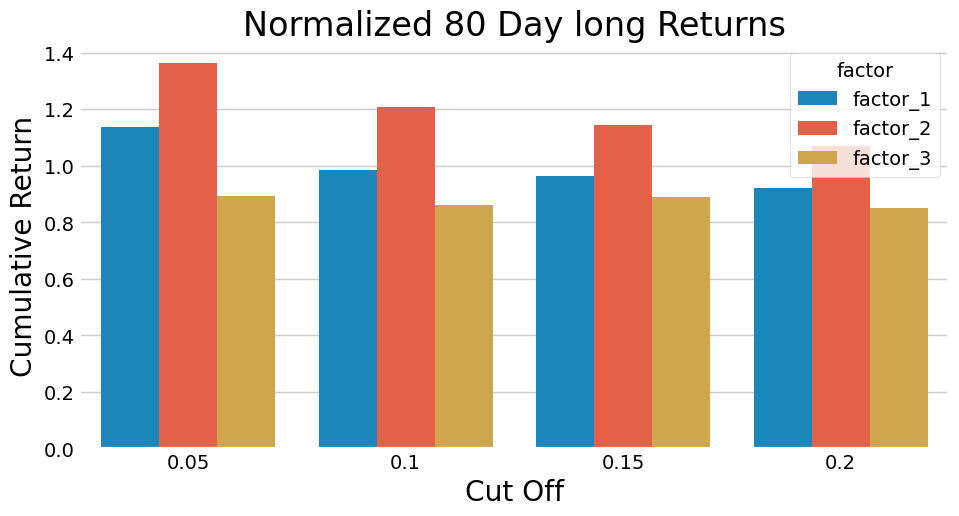

In [ ]:
single_holding_period_side_CV(df, period=80, side="long")

In [ ]:
chunked = (
    # For each of the hyper-parameters
    df.groupby(["holding_period", "cut_off", "side", "factor"])
    # Resample it to a 300 day period, using realized_return_date as the date column
    .resample("300D", on="realized_return_date")
    # Calculate the sum for each 300 day chunk
    .sum(numeric_only=True)
    # Select just the normalized returns
    # Pop the other columns from the index back to regular columns
    # Ends up with columns:
    # - holding_period
    # - cut_off
    # - side
    # - factor
    # - realized_return_date
    # - normalized_return
    .normalized_return.reset_index()
)
chunked


,holding_period,cut_off,side,factor,realized_return_date,normalized_return
0,1,0.05,long,factor_1,2016-03-02,0.098036
1,1,0.05,long,factor_1,2016-12-27,0.046565
2,1,0.05,long,factor_1,2017-10-23,-0.003336
3,1,0.05,long,factor_1,2018-08-19,0.047911
4,1,0.05,long,factor_1,2019-06-15,-0.179253
...,...,...,...,...,...,...
2035,80,0.20,short,factor_3,2018-02-13,-0.052736
2036,80,0.20,short,factor_3,2018-12-10,-0.057312
2037,80,0.20,short,factor_3,2019-10-06,-0.027220
2038,80,0.20,short,factor_3,2020-08-01,-0.380572


In [ ]:
# Now that we have the chunks, we want the median normalized return for each set of hyperparamters
median_normalized_return = (
    chunked.groupby(["holding_period", "cut_off", "side", "factor"])
    .normalized_return.median()
    .rename("median_normalized_return")
    .reset_index()
)
median_normalized_return


,holding_period,cut_off,side,factor,median_normalized_return
0,1,0.05,long,factor_1,0.024652
1,1,0.05,long,factor_2,-0.000202
2,1,0.05,long,factor_3,0.024241
3,1,0.05,short,factor_1,-0.073986
4,1,0.05,short,factor_2,-0.078375
...,...,...,...,...,...
259,80,0.20,long,factor_2,0.075717
260,80,0.20,long,factor_3,0.114923
261,80,0.20,short,factor_1,-0.109245
262,80,0.20,short,factor_2,-0.143042


In [ ]:
long_strats = median_normalized_return.loc[median_normalized_return.side.eq("long")]

best_long_strat = long_strats.loc[long_strats.median_normalized_return.idxmax()]
best_long_strat

holding_period                    40
cut_off                         0.15
side                            long
factor                      factor_1
median_normalized_return    0.155177
Name: 204, dtype: object

In [ ]:
short_strats = median_normalized_return.loc[median_normalized_return.side.eq("short")]

best_short_strat = short_strats.loc[short_strats.median_normalized_return.idxmax()]
best_short_strat

holding_period                     1
cut_off                          0.1
side                           short
factor                      factor_3
median_normalized_return   -0.015525
Name: 11, dtype: object

In [ ]:
# Finally, we want to know the best strategy when using both the long and the short
mixed = (
    median_normalized_return.groupby(["holding_period", "cut_off", "factor"])
    .median_normalized_return.median()
    .reset_index()
)
best_mixed_strat = mixed.loc[mixed.median_normalized_return.idxmax()]
best_mixed_strat


holding_period                    60
cut_off                         0.05
factor                      factor_3
median_normalized_return    0.015284
Name: 110, dtype: object

In [ ]:
(
    df.loc[df.holding_period.eq(60) & df.cut_off.eq(0.05) & df.factor.eq("factor_3")]
    .groupby("realized_return_date")
    .normalized_return.sum()
    .reset_index(drop=True)
)


0       0.001028
1       0.000667
2       0.000998
3       0.000727
4       0.001160
          ...   
1415    0.000756
1416    0.000556
1417    0.000805
1418   -0.000108
1419    0.000071
Name: normalized_return, Length: 1420, dtype: float64

In [ ]:
final_strats = pd.DataFrame(
    dict(
        realized_return_date=df.realized_return_date.unique(),
        long=df.loc[
            df.holding_period.eq(40)
            & df.cut_off.eq(0.15)
            & df.side.eq("long")
            & df.factor.eq("factor_1")
        ].normalized_return.reset_index(drop=True),
        short=df.loc[
            df.holding_period.eq(1)
            & df.cut_off.eq(0.1)
            & df.side.eq("short")
            & df.factor.eq("factor_3")
        ].normalized_return.reset_index(drop=True),
        mixed=df.loc[
            df.holding_period.eq(60) & df.cut_off.eq(0.05) & df.factor.eq("factor_3")
        ]
        .groupby("realized_return_date")
        .normalized_return.sum()
        .reset_index(drop=True),
    ),
).set_index("realized_return_date").cumsum()
final_strats


,long,short,mixed
realized_return_date,,,
2016-03-02,0.002723,-0.008895,0.001028
2016-03-03,0.004901,-0.014876,0.001695
2016-03-04,0.006604,-0.019363,0.002694
2016-03-07,0.008680,-0.026963,0.003420
2016-03-08,0.010458,-0.022127,0.004580
...,...,...,...
2022-01-06,NaN,-0.413888,NaN
2022-01-07,NaN,-0.410783,NaN
2022-01-10,NaN,-0.410363,NaN


In [ ]:
spy = (
    pd.read_csv(
        "spy_returns.csv",
        usecols=["Date", "Cumsum"],
        parse_dates={"realized_return_date": ["Date"]},
    )
    .rename(columns={"Cumsum": "S&P500"})
    .set_index("realized_return_date")
)
spy


,S&P500
realized_return_date,
2016-03-02,0.006372
2016-03-03,0.011352
2016-03-04,0.013452
2016-03-07,0.019723
2016-03-08,0.015107
...,...
2022-11-28,0.296320
2022-11-29,0.294249
2022-11-30,0.325072


In [ ]:
final_strats = pd.concat([final_strats, spy], join="inner", axis="columns")

Text(0.5, 1.0, 'Best Strategies')

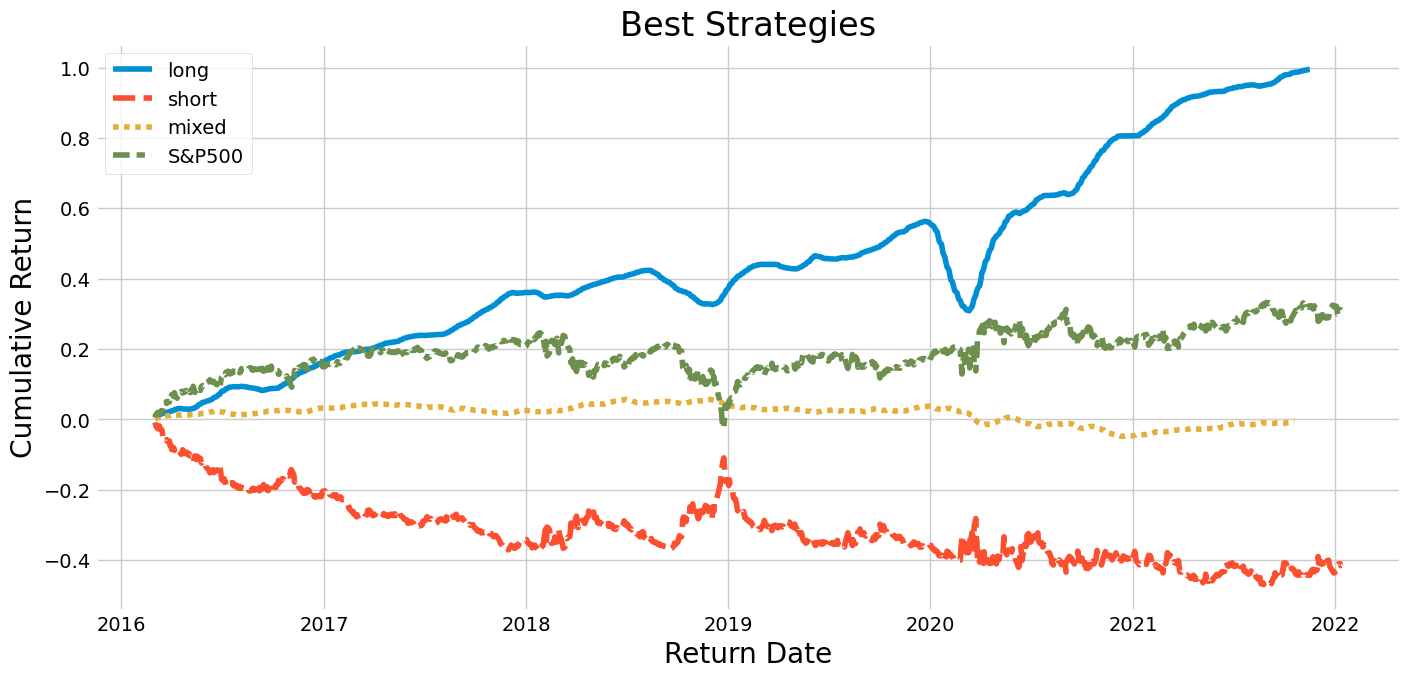

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(ax=ax, data=final_strats)
ax.set_xlabel("Return Date")
ax.set_ylabel("Cumulative Return")
ax.set_title("Best Strategies")

Use k-fold cross validation for the final long strategy

In [127]:
def long_strategy(df_filtered, factor, cut_off, holding_period):    
    columns = [
    "factor",
    "holding_period",
    "cut_off",
    "realized_return_date",
    "side",
    "return",
    ]
    results_df = pd.DataFrame(columns=columns)
    
    adj_holding_period = holding_period - 1

    for idx in range(0, len(dates) - adj_holding_period - 1):
        selection_date = dates[idx]
        start_date = dates[idx + 1]
        end_date = dates[idx + adj_holding_period + 1]

        longs = portfolio_selector_longs(
            df=df_filtered,
            day=selection_date,
            factor=factor,
            percentage=cut_off,
        )
        
        longs_returns_pct = calculate_returns_longs(
            df=df_filtered,
            tickers=longs,
            purchase_date=start_date,
            sell_date=end_date,
        )
                
        longs_return_total = np.mean(longs_returns_pct)

        # add long dataframe
        factor_array = [factor]
        holding_period_array = [holding_period]
        cut_off_array = [cut_off]
        return_date_array = [end_date]
        side_array = ["long"]

        dictionary_l = {
            "factor": factor_array,
            "holding_period": holding_period_array,
            "cut_off": cut_off_array,
            "realized_return_date": return_date_array,
            "side": side_array,
            "return": longs_return_total,
        }
        add_df = pd.DataFrame(data=dictionary_l)
        results_df = pd.concat([results_df, add_df], axis=0)
    results_df = results_df.reset_index(drop=True)
    return results_df               

In [128]:
def shuffle_and_group(array, n):
    shuf = array.ravel()
    np.random.shuffle(shuf)
    shuf = list(shuf)

    groups = []
    for i in range(n):  # ensuring no empty group
        groups.append([shuf.pop()])

    for num in shuf:  # spread the remaining
        groups[np.random.randint(n)].append(num)
    return groups

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("style.mplstyle")

In [130]:
long_original = long_strategy(df_filtered, "factor_1", 0.15, 40)

In [131]:
import random
tickers = df_filtered['ticker'].unique()
random.seed(10)
groups = shuffle_and_group(tickers, 5)

In [157]:
validation_set = []
for group in groups:
    validation_set.append(long_strategy(df_filtered[~df_filtered['ticker'].isin(group)], "factor_1", 0.15, 40))

In [159]:
long_original.loc['Originial'] = long_original['return'].cumsum()/40
data = long_original[['realized_return_date', 'Originial']]

In [160]:
data.loc[:,'val_1'] = validation_set[0]["return"].cumsum()/40
data.loc[:,'val_2'] = validation_set[1]["return"].cumsum()/40
data.loc[:,'val_3'] = validation_set[2]["return"].cumsum()/40
data.loc[:,'val_4'] = validation_set[3]["return"].cumsum()/40
data.loc[:,'val_5'] = validation_set[4]["return"].cumsum()/40

C:\Users\pkuer\AppData\Local\Temp\ipykernel_21944\38032372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'val_1'] = validation_set[0]['return'].cumsum()/40
C:\Users\pkuer\AppData\Local\Temp\ipykernel_21944\38032372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'val_2'] = validation_set[1]["return"].cumsum()/40
C:\Users\pkuer\AppData\Local\Temp\ipykernel_21944\38032372.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [161]:
data = data.set_index("realized_return_date")

Text(0.5, 1.0, 'Cross Validation')

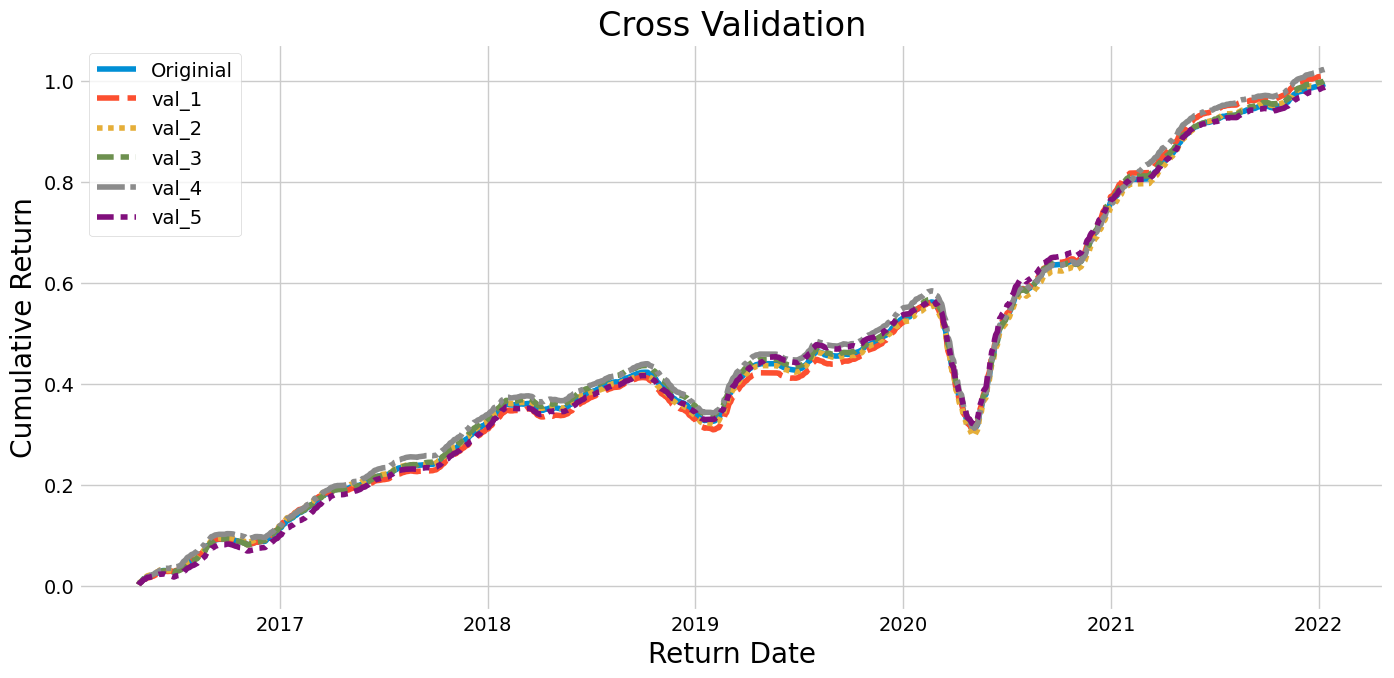

In [162]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(ax=ax, data=data)
ax.set_xlabel("Return Date")
ax.set_ylabel("Cumulative Return")
ax.set_title("Cross Validation")